In [1]:
library(dplyr)
library(reshape2)
library(tibble)
library(igraph)
library(xtable)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)
# library(rgl)
library(pROC)
library(umap)

# library(pheatmap)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [3]:
source("R/calc.R")
source("R/misc.R")
source("R/normalise.R")
source("R/plot.R")
source("R/predict.R")
source("R/subset.R")
source("R/utils.R")

## Import data

In [4]:
### ANNOTATIONS
METADATA_SID <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "data/GSE67684/processed/metadata/pid-metadata_v7.tsv"

metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')
metadata_pid$label <- as.factor(metadata_pid$label)

### DATA
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### Subnetworks

In [4]:
# ## NEA - GFS
# file <- 'tmp/nea_gfs.tsv'
# raw_nea <- read.table(file, sep = "\t", header = T, row.names = 1)
# nea_fltr <- remove_rows(raw_nea, sum(row) == 0)

#### D33

In [4]:
# path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
# path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

# yeoh_d33 <- read.table(path1, sep = "\t", header = T)
# annot_all <- read.table(path2, sep = "\t", header = T)

# annot_all[] <- lapply(annot_all, as.factor)
# yeoh_d33_allps <- log2_transform(normaliseMeanScaling(yeoh_d33))
# # Remove samples that have been curated out of data set
# # Members that have been curated out are no longer in annot_all
# missing_samples <- colnames(yeoh_d33_allps)[
#   !(colnames(yeoh_d33_allps) %in% rownames(annot_all))]
# # Remove patients from D33 that have been curated out
# yeoh_d33 <- yeoh_d33_allps[
#   rownames(yeoh),
#   !(colnames(yeoh_d33_allps) %in% missing_samples)
# ]

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 


In [5]:
# annot_all$class_info <- factor(
#   annot_all$class_info,
#   levels = c('D0', 'D8', 'D33', 'N')
# )

### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [5]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Train/test split: Patients distribution

In [379]:
# # TODO: Do not evaluate to heterogeneous subtypes
# train_distr <- table(
#   Y[sid_train, "subtype"],
#   Y[sid_train, "label"]
# )/2
# test_distr <- table(
#   Y[sid_test, "subtype"],
#   Y[sid_test, "label"]
# )/2

# # # Transfer all relapse samples to test set
# # test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# # train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed May 26 00:37:42 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   4 &   5 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   7 &   1 \\ 
  TEL-AML1 &  20 &   4 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed May 26 00:37:42 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   1 &   0 \\ 
  E2A-PBX1 &   2 &   1 \\ 
  Hyperdiploid &   0 &   0 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   1 &   2 \\ 
  Normal &   0 &   0 \\ 
  Others &   0 &   0 \\ 
  T-ALL &   1 &   1 \\ 
  TEL-AML1 &   9 &   1 \\ 
   \hline
\end{tabular}
\end{table}


## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [6]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

In [18]:
# # Subnetworks are resistant to batch effects
# batch_subnetworks <- identify_batch_features(nea_fltr, annot, method = 'aov')
# length(batch_subnetworks)

### Drug genes

Constant: Subtype, remission

In [10]:
# # Prediction (Drug genes) --------------------------------------------
# ## Drug responsive genes
# #' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
# select_subnetworks <- function(
#   X_subtype, sid_remission,
#   alpha = 0.05, N = 50
# ) {
#   sid <- intersect(sid_remission, colnames(X_subtype))
#   X_subtype_remission <- X_subtype[, sid, drop = F]
#   n_pairs <- ncol(X_subtype_remission) / 2
  
#   if (!is_paired(X_subtype_remission))
#     stop("Patient IDs are not paired..")
  
#   # P-value
#   pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!
#   features <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  
#   return(features)
# }

### M1: Entire data

In [7]:
list_subtype_sids <- lapply(
  subtypes7,
  function(subtype) {
    sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
  }
)

In [8]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj1 <- lapply(
  list_X_subtypes7,
  predict_pipeline_v2,
  X_normal,
  metadata, metadata_pid,
  batch_ps,
  include_tp2 = F
)
names(list_obj1) <- subtypes7

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
No. of features selected = 21
No. of final genes = 14
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
No. of features selected = 239
No. of final genes = 164
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of remission samples in training set = 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 718"
[1] "No. of features (p-value) = 2508"
[1] "No. of features (log2-fc) = 283"
No. of features selected = 281
No. of final genes = 216
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of remission samples in training set = 31"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets 

In [9]:
list_X_y <- lapply(
  list_obj1,
  function(obj) cbind(
    obj$X_y,
    metadata_pid[rownames(obj$X_y), "treatment", drop = FALSE]
  )
)

In [10]:
boxplots <- lapply(
  list_X_y, plot_boxplots_v2,
  colour_by = "treatment", shape_by = "label"
)

[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          
[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          
[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          
[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          
[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          
[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_

#### Plot by treatment

[1] "erm1_ratio2"         "l2norm_ratio2"       "angle_d0d8_d0normal"
[4] "log_mrd_d33"         "p_d8"                "p_d33"              
[7] "label"               "treatment"          


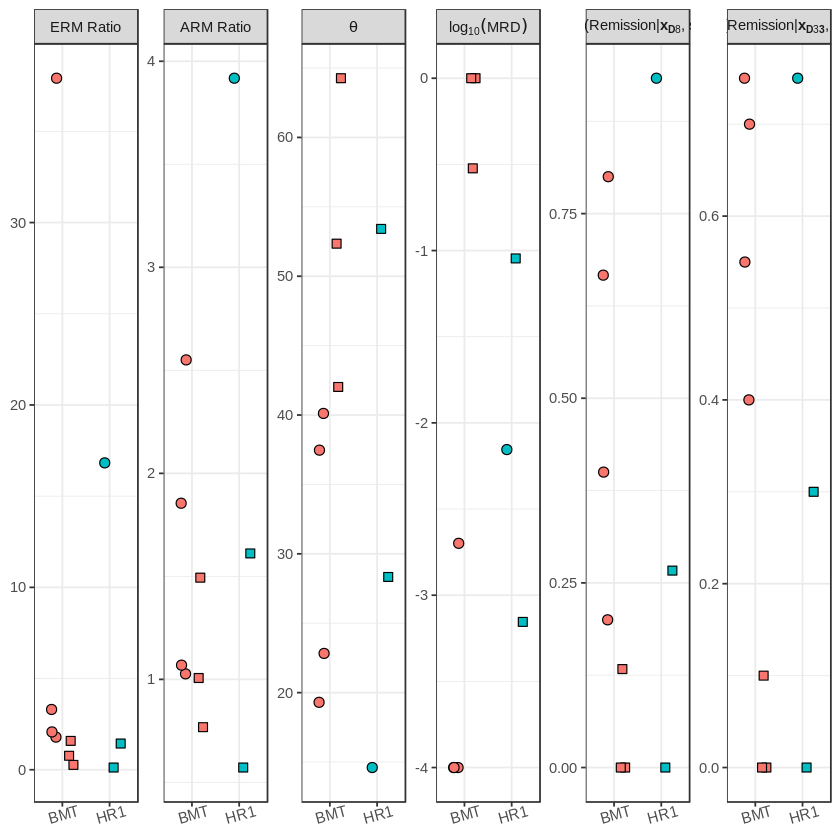

In [11]:
plot_boxplots_v2(list_X_y[[1]], colour_by = "treatment", shape_by = "label")

#### Save predicted probas

In [355]:
# all_probas_d8 <- lapply(unname(list_obj1), function(obj) obj$X_y["p_d8"])
# all_p_d8 <- do.call(rbind, all_probas_d8)
# write.table(all_p_d8, "tmp/all_p_d8.tsv", quote = F, sep = "\t")

In [356]:
# all_probas_d33 <- lapply(unname(list_obj1), function(obj) obj$X_y["p_d33"])
# all_p_d33 <- do.call(rbind, all_probas_d33)
# write.table(all_p_d33, "tmp/all_p_d33.tsv", quote = F, sep = "\t")

In [322]:
# homogeneous_objs <- list_obj1[subtypes5] # select homogeneous subtypes
# homogeneous_probas <- lapply(
#   unname(homogeneous_objs),
#   function(obj) obj$X_y["p_d33"]
# )
# p_d33 <- do.call(rbind, homogeneous_probas) 

In [323]:
# write.table(p_d33, "tmp/p_d33.tsv", quote = F, sep = "\t")

#### Consolidate p(remission|x)

In [155]:
homogeneous_objs <- list_obj1[subtypes7] # select homogeneous subtypes
names(homogeneous_objs) <- NULL # avoid funny row.names
homogeneous_probas <- lapply(homogeneous_objs, function(obj) obj$p)
m1_p_alltrain <- do.call(rbind, homogeneous_probas) 

In [156]:
write.table(m1_p_alltrain, "tmp/m1-p_alltrain_allsubtypes.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline_v2,
#   X_normal, metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

In [98]:
# boxplots <- lapply(list_obj1, function(obj) plot_boxplots(obj$X_y))

# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_alltrain_simulated-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

In [99]:
# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_treatment-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

## Investigate: Specific patient IDs

#### Return raw ERM/ARM values

In [99]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline_v3 <- function(
  X_subtype,
  X_normal,
  metadata_sid,
  metadata_pid,
  batch_genes = NULL,
  class_genes = NULL,
  samples = NULL,
  include_tp2 = FALSE,
  return_features = FALSE
) {
  sid_remission <- colnames(X_subtype)[
    metadata_sid[colnames(X_subtype), "label"] == 0
  ]

  if (is.null(class_genes))
    class_genes <- getLocalGenes(X_subtype, sid_remission)
    # # Save drug response genes
    # subtype <- unique(metadata_sid[colnames(X_subtype), "subtype"])
    # writeLines(class_genes, sprintf("tmp/response-%s.txt", subtype))

  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }

  cat(sprintf("No. of features selected = %d\n", length(class_genes)))
  cat(sprintf("No. of final genes = %d\n", length(selected_genes)))

  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])

  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$log_mrd_d33 <- log10(metadata_pid[rownames(V), "d33_mrd"])
  
  if (return_features) {
    return(V)
  }
  
  if (include_tp2) {
    # Include MRD TP2
    V$log_mrd_tp2 <- log10(metadata_pid[rownames(V), "wk12_mrd"])
    features <- c(
      "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
      "log_mrd_d33", "log_mrd_tp2"
    )
    direction <- c("<", "<", ">", ">", ">")
    X_train <- V[!is.na(V$log_mrd_tp2), features]
  } else {
    # Select features and specify order
    features <- c(
      "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal", "log_mrd_d33"
    )
    direction <- c("<", "<", ">", ">")
    X_train <- V[features]
  }

  prediction <- calc_p_remission_x_v2(
    X_train, X_train, metadata_pid, direction, samples, include_tp2
  )
  # Concatenate features and probabilities
  X_y <- cbind(X_train, prediction$p)

  list(p_remission_xi = prediction$p_remission_xi, X_y = X_y)
}

In [49]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_V <- lapply(
  list_X_subtypes7,
  predict_pipeline_v3,
  X_normal,
  metadata, metadata_pid,
  batch_ps,
  include_tp2 = F,
  return_features = TRUE
)
names(list_V) <- subtypes7

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
No. of features selected = 21
No. of final genes = 14
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
No. of features selected = 239
No. of final genes = 164
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 718"
[1] "No. of features (p-value) = 2508"
[1] "No. of features (log2-fc) = 283"
No. of features selected = 281
No. of final genes = 216
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
No. of features selected = 262
No. of final

#### Investigate patients with discrepancy between features

In [226]:
FILE1 <- "tmp/pid_relapse_srir-d8.txt"
FILE2 <- "tmp/pid_relapse_srir-d33.txt"
pid_relapse_d8 <- sort(readLines(FILE1))
pid_relapse_d33 <- sort(readLines(FILE2))

In [227]:
p_d8 <- read.table("tmp/p_d8.tsv", sep = "\t")
p_d33 <- read.table("tmp/p_d33.tsv", sep = "\t")
p_tp2 <- read.table("tmp/p_tp2.tsv", sep = "\t")

In [228]:
p_d8[pid_relapse_d8, , drop = F]
p_d33[pid_relapse_d33, , drop = F]

,p_d8
,<dbl>
P029,0.2528736
P056,0.2666667
P136,0.2988506
P151,0.4166667


,p_d33
,<dbl>
P007,0.2812500
P034,0.3017241
P056,0.3000000
P094,0.2672414
P136,0.4741379
P151,0.3750000


#### Relapse patients with good ERM
- Only in subtypes BCR-ABL, T-ALL, TEL-AML1

In [191]:
features <- c(
  "erm1", "l2norm_d0_d8", "erm1_ratio2",
  "l2norm_ratio2", "angle_d0d8_d0normal", "log_mrd_d33"
)
list_V_fltr <- lapply(list_V, subset, select = features)
V_fltr <- bind_rows(lapply(list_V_fltr, rownames_to_column), .id = "subtype")
V_fltr <- cbind(
  V_fltr,
  label = metadata_pid[V_fltr$rowname, "label"]
)

V1 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

In [220]:
# Difference in rank / total number
# Rank three features. Rank of 1 means it is more likely to achieve remission
list_ranks <- lapply(
  list_V_fltr,
  function(X) data.frame(
    erm = rank(-X$erm1),
    arm = rank(-X$l2norm_d0_d8),
    theta = rank(X$angle_d0d8_d0normal),
    row.names = rownames(X)
  )
)

list_rankdiff <- lapply(
  list_ranks,
  function(X) {
    x <- abs((X$erm - X$theta) / nrow(X))
    names(x) <- rownames(X)
    x
  }
)

rankdiffs <- do.call(c, unname(list_rankdiff))
# hist(rankdiffs, breaks = 20)

THRESHOLD <- 0.2
pid_discrepancy <- names(rankdiffs)[rankdiffs > THRESHOLD]

# Investigating patients with discrepancy between features
y1 <- metadata_pid[pid_discrepancy, c("subtype", "label")] %>%
  subset(!(subtype %in% c("Hyperdiploid", "Others")))

p_d8[rownames(y1), , drop = FALSE]

,p_d8
,<dbl>
P152,0.1333333
P051,0.6666667
P004,0.6250000
P007,0.2500000
P010,0.1250000
P012,0.3750000
P120,0.8045977
P135,0.7126437


In [222]:
# Difference in rank / total number
# Rank three features. Rank of 1 means it is more likely to achieve remission
list_ranks <- lapply(
  list_V_fltr,
  function(X) data.frame(
    erm = rank(-X$erm1),
    arm = rank(-X$l2norm_d0_d8),
    theta = rank(X$angle_d0d8_d0normal),
    row.names = rownames(X)
  )
)

list_rankdiff <- lapply(
  list_ranks,
  function(X) {
    x <- abs((X$arm - X$theta) / nrow(X))
    names(x) <- rownames(X)
    x
  }
)

rankdiffs <- do.call(c, unname(list_rankdiff))
# hist(rankdiffs, breaks = 20)

THRESHOLD <- 0.4
pid_discrepancy <- names(rankdiffs)[rankdiffs > THRESHOLD]

# Investigating patients with discrepancy between features
y1 <- metadata_pid[pid_discrepancy, c("subtype", "label")] %>%
  subset(!(subtype %in% c("Hyperdiploid", "Others")))

p_d8[rownames(y1), , drop = FALSE]

,p_d8
,<dbl>
P057,0.0000000
P184,0.0000000
P051,0.6666667
P145,0.4000000
P160,0.7777778
P167,0.0000000
P004,0.6250000
P010,0.1250000


In [194]:
V2 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "E2A-PBX1", "T-ALL", "MLL", "TEL-AML1"))
V3 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

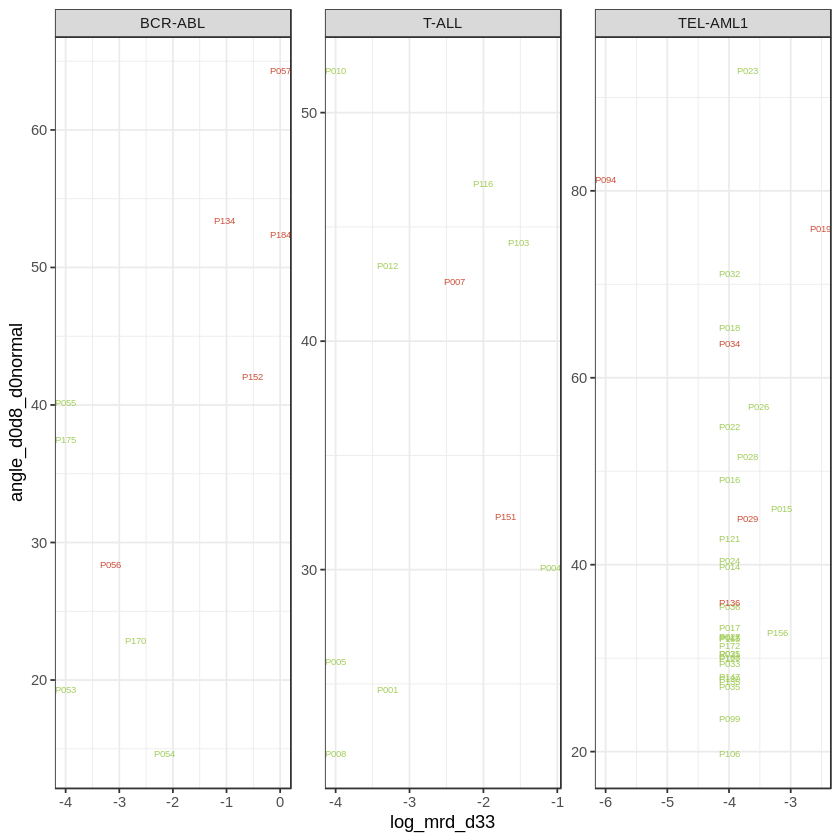

In [196]:
ax <- ggplot(
  V2,
  aes(
    x = l2norm_d0_d8, y = angle_d0d8_d0normal,
    color = label, fill = label,
    label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
#   geom_point(
#     position = position_jitterdodge(),
#     pch = 21, cex = 2, show.legend = FALSE
#   ) +
  geom_text(
    cex = 2, show.legend = FALSE
  ) +
  scale_fill_manual(values = COL_LABEL) +
  scale_color_manual(values = COL_LABEL)

ax

ggsave("~/Dropbox/tmp/MRD.pdf", ax, width = 7, height = 5)

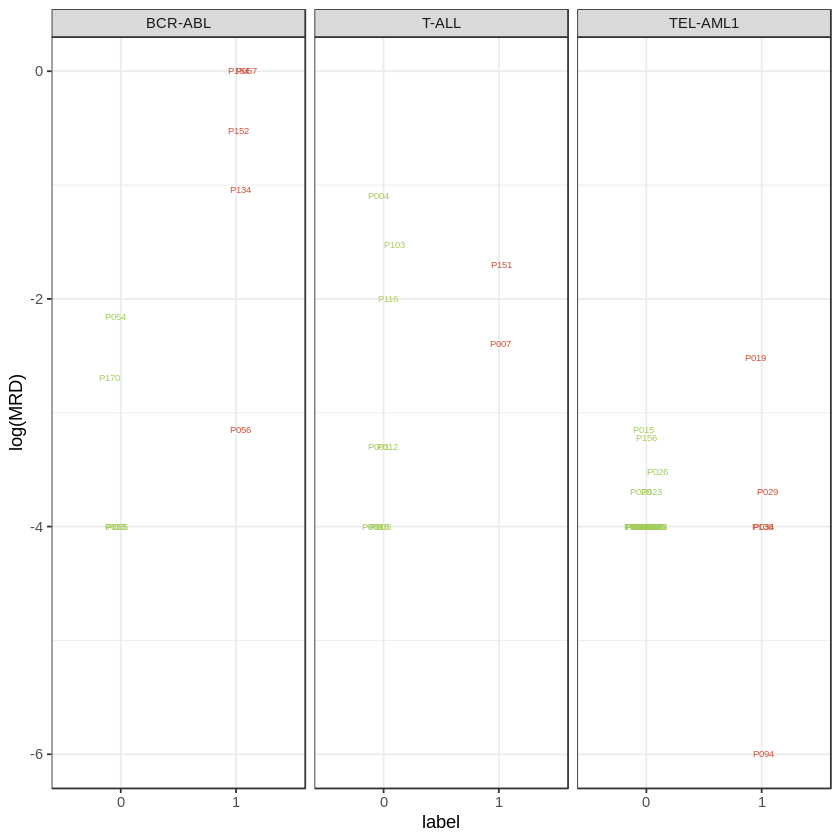

In [205]:
ax <- ggplot(
  V3,
  aes(
    x = label, y = log_mrd_d33,
    color = label, fill = label, label = rowname)
) +
  facet_wrap(~subtype) +
  geom_text(
    position = position_jitterdodge(),
    cex = 2, show.legend = FALSE
  ) +
  scale_color_manual(values = COL_LABEL) +
  labs(y = "log(MRD)")

ax

ggsave("~/Dropbox/tmp/log_mrd.pdf", ax, width = 5, height = 2.5)

#### Individual features

In [38]:
list_X_y <- lapply(
  list_obj1,
  function(obj) rownames_to_column(obj$X_y)
)
X_y <- bind_rows(list_X_y, .id = "subtype")
X_y_sub <-  filter(X_y, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

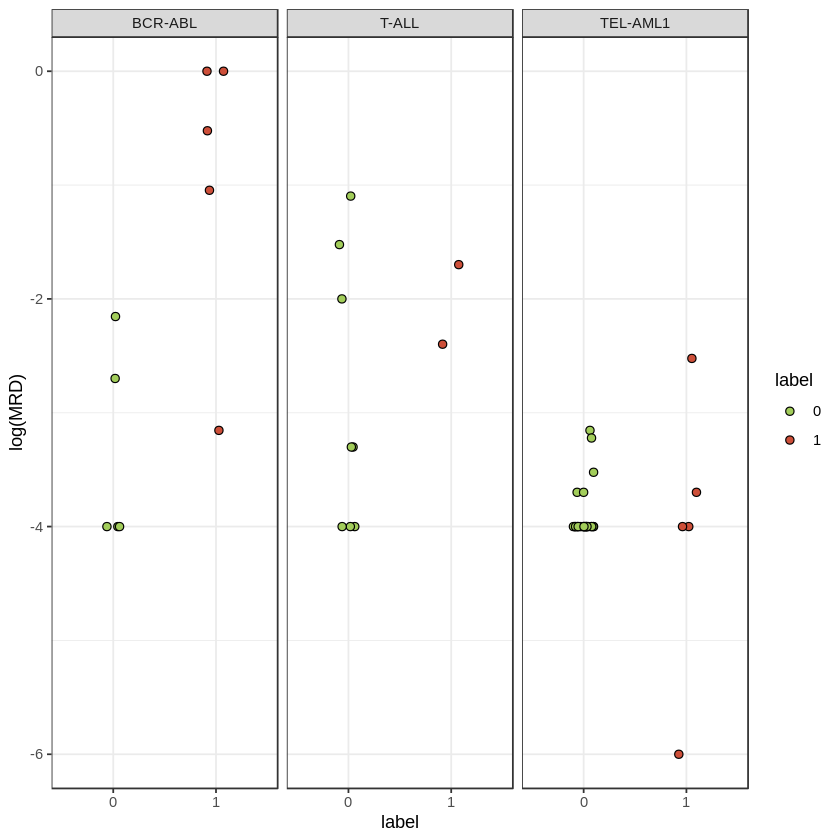

In [40]:
ax <- ggplot(
  X_y_sub,
  aes(x = label, y = log_mrd_d33, fill = label)
) +
  facet_wrap(~subtype) +
  geom_point(position = position_jitterdodge(), pch = 21, cex = 2) +
  scale_fill_manual(values = COL_LABEL) +
  labs(y = "log(MRD)")
ax

# ggsave("~/Dropbox/tmp/log_mrd.pdf", ax, width = 5, height = 2.5)

In [103]:
X_y %>%
  rownames_to_column() %>%
  filter(subtype %in% c("TEL-AML1") & label == 1)

rowname,subtype,erm1_ratio2,l2norm_ratio2,angle_d0d8_d0normal,log_mrd_d33,p_d8,p_d33,label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
P019,TEL-AML1,0.04662865,0.4659208,75.88335,-2.522879,0.02298851,0.01724138,1
P029,TEL-AML1,0.55129774,0.8489252,44.86219,-3.698970,0.25287356,0.23275862,1
P034,TEL-AML1,0.17666919,0.5215379,63.57314,-4.000000,0.06896552,0.30172414,1
P094,TEL-AML1,0.02149864,0.3998272,81.18984,-6.000000,0.02298851,0.26724138,1
P136,TEL-AML1,0.81113048,1.1008967,35.89147,-4.000000,0.29885057,0.47413793,1


In [69]:
# Load relapse patients predicted as SR/IR
file <- "tmp/pid_relapse_srir.txt"
pid <- readLines(file)
X_y[pid,]

,subtype,erm1_ratio2,l2norm_ratio2,angle_d0d8_d0normal,log_mrd_d33,p_d8,p_d33,label
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
P056,BCR-ABL,1.43645701,1.6113608,28.33446,-3.154902,0.26666667,0.3000000,1
P007,T-ALL,0.75701293,0.9710019,42.59169,-2.397940,0.25000000,0.2812500,1
P151,T-ALL,1.15021746,1.2218995,32.29299,-1.698970,0.41666667,0.3750000,1
P034,TEL-AML1,0.17666919,0.5215379,63.57314,-4.000000,0.06896552,0.3017241,1
P094,TEL-AML1,0.02149864,0.3998272,81.18984,-6.000000,0.02298851,0.2672414,1
P136,TEL-AML1,0.81113048,1.1008967,35.89147,-4.000000,0.29885057,0.4741379,1


## Troubleshoot

In [77]:
# WRONG
list_obj2[[1]]$P
list_obj2[[1]]$X_y

,pid,label,p,p_wo_mrd,erm1_ratio2,l2norm_ratio2,mrd,angle_d0d8_d0normal
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P053,P053,0,0.65,0.6666667,0.6,0.6,0.6,0.8
P054,P054,0,0.95,0.9333333,0.8,1.0,1.0,1.0
P055,P055,0,0.30,0.2000000,0.2,0.2,0.6,0.2
P056,P056,1,0.35,0.2666667,0.0,0.4,0.6,0.4
P057,P057,1,0.25,0.0000000,0.0,0.0,1.0,0.0
P134,P134,1,0.25,0.0000000,0.0,0.0,1.0,0.0
P152,P152,1,0.35,0.1333333,0.0,0.4,1.0,0.0
P170,P170,0,0.80,0.8000000,1.0,0.8,0.8,0.6
P175,P175,0,0.45,0.4000000,0.4,0.4,0.6,0.4


,angle_d0d8_d0normal,erm1_ratio2,l2norm_ratio2,log_mrd,p,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
P053,19.30266,3.3045166,1.8549851,-4.0000000,0.65,0
P054,14.60372,16.8250723,3.9177600,-2.1549020,0.95,0
P055,40.11626,1.7879367,1.0268466,-4.0000000,0.30,0
P056,28.33446,1.4364570,1.6113608,-3.1549020,0.35,1
P057,64.26825,0.2648847,0.7681211,0.0000000,0.25,1
P134,53.41166,0.1202425,0.5721590,-1.0457575,0.25,1
P152,42.02373,1.5813655,1.4937770,-0.5228787,0.35,1
P170,22.82434,37.9163917,2.5505411,-2.6989700,0.80,0
P175,37.46942,2.0726382,1.0690815,-4.0000000,0.45,0


In [80]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
)
list_obj2 <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal, metadata, metadata_pid,
  batch_ps
)
names(list_obj2) <- subtypes7

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 718"
[1] "No. of features (p-value) = 2508"
[1] "No. of features (log2-fc) = 283"
[1] "No. of selected genes = " "281"                     
[1] "No. of final genes = " "216"                  
[1] "NO. OF SAMPLES IN CENTROID: 31"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of 

In [60]:
boxplots <- lapply(list_obj1, function(obj) plot_boxplots(obj$X_y))

for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/features_alltrain-%s.pdf", subtypes7[i])
  ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
}

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

In [119]:
#' Plots boxplot of features, p_rem WITHOUT global ERM
#' Provides p-values from wilcoxon rank-sum test
plot_boxplots2 <- function(X_y, cex = 2.5) {
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "p_wo_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), '*, s)')",
    "paste('P(Remission|', bold(x), ', s)')"
  )
  
  long_X_y <- melt(
    X_y,
    id = c("label", "treatment_type"),
    variable.name = "feature"
  )
  
  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  levels(long_X_y$label) <- c("Remission", "Relapse")
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = label, y = value)
  ) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    geom_boxplot(
      aes(group = label),
      outlier.shape = NA
    ) +
    geom_point(
      aes(fill = label),
      position = position_jitterdodge(
        jitter.width = .8,
        dodge.width = 1.2,
      ),
      cex = cex, pch = 21, alpha = 1,
      col = "black", show.legend = F
    ) +
    scale_fill_manual(values = COL_LABEL) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(angle = 15),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    p_labs <- sapply(
      FEAT_ORDER,
      function(idx) {
        list_feat <- split(X_y[, idx], X_y$label)
        tryCatch(
          {
            htest <- wilcox.test(
              list_feat[[1]], list_feat[[2]], exact = T
            )
            sprintf("p = %.3f", htest$p.value)
          },
          error = function(err) {
            print(err)
            return(err)
          }
        )
      }
    )
    
    ann_text <- data.frame(
      feature = factor(
        FEAT_ORDER,
        levels = FEAT_ORDER,
        labels = FEAT_LABS
      ),
      value = c(
        max(X_y[FEAT_ORDER[1]]),
        max(X_y[FEAT_ORDER[2]]),
        min(X_y[FEAT_ORDER[3]]),        
        min(X_y[FEAT_ORDER[4]]),
        max(X_y[FEAT_ORDER[5]]),
        max(X_y[FEAT_ORDER[6]])
      ),
      label = p_labs
    )
    ann_text <- na.omit(ann_text)

    ax_jitter <- ax_jitter +
      geom_text(
        data = ann_text,
        aes(x = 1.5, y = value, label = label),
        size = 3, # colour = "black",
        hjust = 0
      )
  }
  
  ax_jitter
}

In [120]:
boxplots <- lapply(list_obj1, function(obj) plot_boxplots2(obj$X_y))

for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/features_alltrain1-%s.pdf", subtypes7[i])
  ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
}

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

### Plot: Against MASPORE risk level

In [62]:
#' Plots boxplot of features, p_rem WITHOUT global ERM
#' Provides p-values from wilcoxon rank-sum test
plot_boxplots1 <- function(X_y, cex = 2.5) {
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ', s)')"
  )
  
  long_X_y <- melt(
    X_y,
    id = c("label", "treatment_type"),
    variable.name = "feature"
  )
  print(head(long_X_y))
  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  levels(long_X_y$label) <- c("Remission", "Relapse")
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = treatment_type, y = value)
  ) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    geom_point(
      aes(fill = label),
      position = position_jitterdodge(
        jitter.width = .8,
        dodge.width = 1.2,
      ),
      cex = cex, pch = 21, alpha = 1,
      col = "black", show.legend = F
    ) +
    scale_fill_manual(values = COL_LABEL) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(angle = 15),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
#   # Jitter plot: p-value label
#   # Both group sizes must be > 1
#   if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
#     p_labs <- sapply(
#       FEAT_ORDER,
#       function(idx) {
#         list_feat <- split(X_y[, idx], X_y$label)
#         tryCatch(
#           {
#             htest <- wilcox.test(
#               list_feat[[1]], list_feat[[2]], exact = T
#             )
#             sprintf("p = %.3f", htest$p.value)
#           },
#           error = function(err) {
#             print(err)
#             return(err)
#           }
#         )
#       }
#     )
    
#     ann_text <- data.frame(
#       feature = factor(
#         FEAT_ORDER,
#         levels = FEAT_ORDER,
#         labels = FEAT_LABS
#       ),
#       value = c(
#         max(X_y[FEAT_ORDER[1]]),
#         max(X_y[FEAT_ORDER[2]]),
#         min(X_y[FEAT_ORDER[3]]),        
#         min(X_y[FEAT_ORDER[4]]),
#         max(X_y[FEAT_ORDER[5]])
#       ),
#       lab = p_labs
#     )
#     ann_text <- na.omit(ann_text)

#     ax_jitter <- ax_jitter +
#       geom_text(
#         data = ann_text,
#         aes(x = 1.5, y = value, label = lab),
#         size = 3, # colour = "black",
#         hjust = 0
#       )
#   }
  
  ax_jitter
}

In [63]:
boxplots <- lapply(list_obj1, function(obj) plot_boxplots1(obj$X_y, cex = 3.2))
names(boxplots) <- subtypes7

  label treatment_type             feature    value
1     0            BMT angle_d0d8_d0normal 19.30266
2     0             HR angle_d0d8_d0normal 14.60372
3     0            BMT angle_d0d8_d0normal 40.11626
4     1             HR angle_d0d8_d0normal 28.33446
5     1            BMT angle_d0d8_d0normal 64.26825
6     1             HR angle_d0d8_d0normal 53.41166
  label treatment_type             feature    value
1     0             SR angle_d0d8_d0normal 42.50210
2     0             SR angle_d0d8_d0normal 28.47382
3     0             IR angle_d0d8_d0normal 33.15841
4     1             SR angle_d0d8_d0normal 77.99727
5     0             SR angle_d0d8_d0normal 32.41103
6     0             SR angle_d0d8_d0normal 29.78878
  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 41.73178
2     1             IR angle_d0d8_d0normal 50.76522
3     0             SR angle_d0d8_d0normal 46.81432
4     0             SR angle_d0d8_d0normal 52.80239
5     0     

In [59]:
for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/features_alltrain1-%s.pdf", subtypes7[i])
  ggsave(wpath, boxplots[[i]], width = 12, height = 4)
}

Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning mess

## Subnetworks

In [61]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_subnetwork <- function(
  subtype, list_X, X_normal,
  metadata, metadata_mrd,
  batch_features = NULL,
  save.rds = FALSE
) {
  X_subtype <- list_X[[subtype]]
  
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  class_features <- select_subnetworks(X_subtype, sid_remission)
  if (is.null(batch_features)) {
    selected_genes <- class_features
  } else {
    selected_genes <- setdiff(class_features, batch_features)
  }
  
  print(c("No. of selected genes = ", length(class_features)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  if (save.rds) {
    file <- sprintf('tmp/subnetworks-%s.RDS', subtype) 
    saveRDS(list(response, normal), file)
  }
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"]

  prediction_obj <- predict_plot(
    V, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(prediction_obj)
}

In [62]:
X_normal <- nea_fltr[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) nea_fltr[,
    sid_alltrain_local[annot[sid_alltrain_local, "subtype"] == subtype]
  ]
)
names(list_X_subtypes7) <- subtypes7

list_obj1 <- lapply(
  subtypes7,
  predict_subnetwork,
  list_X_subtypes7,
  X_normal, annot, yeoh_label,
  save.rds = FALSE
)

[1] "No. of selected genes = " "7"                       
[1] "No. of final genes = " "7"                    
[1] "NO. OF SAMPLES IN CENTROID: 5"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "52"                      
[1] "No. of final genes = " "52"                   
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of selected genes = " "121"                     
[1] "No. of final genes = " "121"                  
[1] "NO. OF SAMPLES IN CENTROID: 31"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "30"                      
[1] "No. of final genes = " "30"                   
[1] "NO. OF SAMPLES IN CENTROID: 3"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "143"                     
[1] "No. of final genes = " "143"                  
[1] "NO. OF SAMPLES IN CENTROID: 63"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "66"                      
[1] "No. of final genes = " "66"                   
[1] "NO. OF SAMPLES IN CENTROID: 8"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "102"                     
[1] "No. of final genes = " "102"                  
[1] "NO. OF SAMPLES IN CENTROID: 29"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [70]:
list_boxplots <- lapply(list_obj1, function(obj) obj$plot)
names(list_boxplots) <- subtypes7

In [71]:
for (subtype in subtypes7) {
  wpath <- sprintf('~/Dropbox/tmp/nea_gfs-%s.pdf', subtype)
  ggsave(wpath, list_boxplots[[subtype]], width = 9, height = 2.5)
}

### Concatenate subnetwork features

In [82]:
# Save scaled subnetwork values to concatenate with probeset values
# Unit scaling of each row
scaled_nea <- t(scale(t(nea_fltr)))

X_normal <- scaled_nea[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) scaled_nea[,
    sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
  ]
)
names(list_X_subtypes7) <- subtypes7
list_obj1 <- lapply(
  subtypes7,
  predict_subnetwork,
  list_X_subtypes7,
  X_normal, metadata_sid, yeoh_label,
  save.rds = TRUE
)

[1] "No. of selected genes = " "7"                       
[1] "No. of final genes = " "7"                    
[1] "NO. OF SAMPLES IN CENTROID: 5"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "52"                      
[1] "No. of final genes = " "52"                   
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of selected genes = " "121"                     
[1] "No. of final genes = " "121"                  
[1] "NO. OF SAMPLES IN CENTROID: 31"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "30"                      
[1] "No. of final genes = " "30"                   
[1] "NO. OF SAMPLES IN CENTROID: 3"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "143"                     
[1] "No. of final genes = " "143"                  
[1] "NO. OF SAMPLES IN CENTROID: 63"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "66"                      
[1] "No. of final genes = " "66"                   
[1] "NO. OF SAMPLES IN CENTROID: 8"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "102"                     
[1] "No. of final genes = " "102"                  
[1] "NO. OF SAMPLES IN CENTROID: 29"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [83]:
#' Concatenates probesets with subnetworks
#'
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#'
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_concat <- function(
  subtype, list_X, X_normal,
  metadata, metadata_mrd,
  batch_genes = NULL
) {
  X_subtype <- list_X[[subtype]]
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  # Scaled features will fail selection by getLocalGenes due to expression threshold
  class_genes <- select_subnetworks(X_subtype, sid_remission)
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  cat(sprintf("No. of selected genes = %d\n", length(class_genes)))
  cat(sprintf("No. of final genes = %d\n", length(selected_genes)))
  
  file <- sprintf('tmp/subnetworks-%s.RDS', subtype)
  subnetworks <- readRDS(file)
  
  # Subtype and normal samples
  response <- cbind(
    t(X_subtype[selected_genes, ]),
    subnetworks[[1]]
  )
  normal <- cbind(
    t(X_normal[selected_genes, ]),
    subnetworks[[2]]
  )

  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"]
  
  prediction_obj <- predict_plot(
    V, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(prediction_obj)
}

In [84]:
# Unit scaling of each row
data_scaled <- t(scale(t(data)))

X_normal <- data_scaled[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype, sid) data_scaled[, sid[metadata_sid[sid, "subtype"] == subtype]],
  sid_alltrain_local
)
names(list_X_subtypes7) <- subtypes7

list_obj1 <- lapply(
  subtypes7,
  predict_concat,
  list_X_subtypes7,
  X_normal, metadata_sid, yeoh_label,
  batch_ps
)

No. of selected genes = 170
No. of final genes = 79
[1] "NO. OF SAMPLES IN CENTROID: 5"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

No. of selected genes = 744
No. of final genes = 398
[1] "NO. OF SAMPLES IN CENTROID: 5"
No. of selected genes = 2508
No. of final genes = 1418
[1] "NO. OF SAMPLES IN CENTROID: 31"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

No. of selected genes = 614
No. of final genes = 339
[1] "NO. OF SAMPLES IN CENTROID: 3"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

No. of selected genes = 3081
No. of final genes = 1725
[1] "NO. OF SAMPLES IN CENTROID: 63"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

No. of selected genes = 606
No. of final genes = 340
[1] "NO. OF SAMPLES IN CENTROID: 8"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

No. of selected genes = 2765
No. of final genes = 1491
[1] "NO. OF SAMPLES IN CENTROID: 29"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [87]:
list_boxplots <- lapply(list_obj1, function(obj) obj$plot)
names(list_boxplots) <- subtypes7
for (subtype in subtypes7) {
  wpath <- sprintf('~/Dropbox/tmp/concat_features-%s.pdf', subtype)
  ggsave(wpath, list_boxplots[[subtype]], width = 9, height = 2.5)
}

In [88]:
# Ablation test: Scaled probesets only
# Unit scaling of each row
data_scaled <- t(scale(t(data)))
X_normal <- data_scaled[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype, sid) data_scaled[, sid[metadata_sid[sid, "subtype"] == subtype]],
  sid_alltrain_local
)
names(list_X_subtypes7) <- subtypes7

list_obj1 <- lapply(
  subtypes7,
  predict_subnetwork,
  list_X_subtypes7,
  X_normal, metadata_sid, yeoh_label,
  batch_ps,
  save.rds = FALSE
)

[1] "No. of selected genes = " "170"                     
[1] "No. of final genes = " "79"                   
[1] "NO. OF SAMPLES IN CENTROID: 5"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "744"                     
[1] "No. of final genes = " "398"                  
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of selected genes = " "2508"                    
[1] "No. of final genes = " "1418"                 
[1] "NO. OF SAMPLES IN CENTROID: 31"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "614"                     
[1] "No. of final genes = " "339"                  
[1] "NO. OF SAMPLES IN CENTROID: 3"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "3081"                    
[1] "No. of final genes = " "1725"                 
[1] "NO. OF SAMPLES IN CENTROID: 63"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "606"                     
[1] "No. of final genes = " "340"                  
[1] "NO. OF SAMPLES IN CENTROID: 8"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "2765"                    
[1] "No. of final genes = " "1491"                 
[1] "NO. OF SAMPLES IN CENTROID: 29"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [90]:
list_boxplots <- lapply(list_obj1, function(obj) obj$plot)
names(list_boxplots) <- subtypes7
for (subtype in subtypes7) {
  wpath <- sprintf('~/Dropbox/tmp/scaled_pval-%s.pdf', subtype)
  ggsave(wpath, list_boxplots[[subtype]], width = 9, height = 2.5)
}

#### Plot: Differential subnetworks

In [76]:
X_normal <- nea_fltr[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) nea_fltr[,
    sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]
  ]
)
names(list_X_subtypes7) <- subtypes7

list_obj1 <- lapply(
  subtypes7,
  predict_subnetwork,
  list_X_subtypes7,
  X_normal, metadata_sid, yeoh_label,
  save.rds = TRUE
)

[1] "No. of selected genes = " "7"                       
[1] "No. of final genes = " "7"                    
[1] "NO. OF SAMPLES IN CENTROID: 5"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "52"                      
[1] "No. of final genes = " "52"                   
[1] "NO. OF SAMPLES IN CENTROID: 5"
[1] "No. of selected genes = " "121"                     
[1] "No. of final genes = " "121"                  
[1] "NO. OF SAMPLES IN CENTROID: 31"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "30"                      
[1] "No. of final genes = " "30"                   
[1] "NO. OF SAMPLES IN CENTROID: 3"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "143"                     
[1] "No. of final genes = " "143"                  
[1] "NO. OF SAMPLES IN CENTROID: 63"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "66"                      
[1] "No. of final genes = " "66"                   
[1] "NO. OF SAMPLES IN CENTROID: 8"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

[1] "No. of selected genes = " "102"                     
[1] "No. of final genes = " "102"                  
[1] "NO. OF SAMPLES IN CENTROID: 29"


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [77]:
list_differential_subnetworks <- list()
for (subtype in subtypes7) {
  file <- sprintf('tmp/subnetworks-%s.RDS', subtype) 
  obj <- readRDS(file)
  list_differential_subnetworks[[subtype]] <- colnames(obj[[1]])
}
differential_subnetworks <- unique(do.call(c, list_differential_subnetworks))

In [79]:
d0_nea_differential <- nea_fltr[
  differential_subnetworks,
  metadata_sid[colnames(nea_fltr), 'class_info'] == 'D0'
]
umap_obj <- umap(t(d0_nea_differential))
ax_umap <- ggplot_umap(umap_obj, metadata_sid, col = 'subtype')
ggsave('~/Dropbox/tmp/umap-differential_nea.pdf',
       ax_umap, width = 9, height = 5)

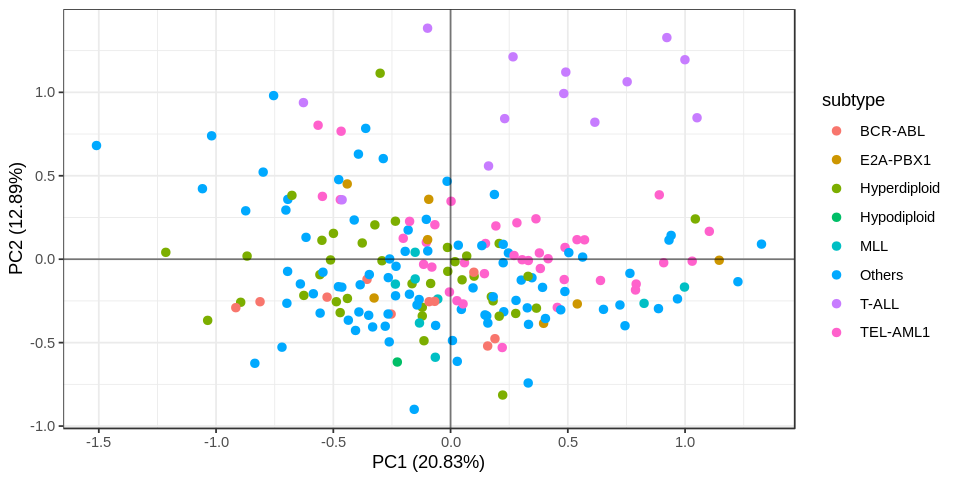

In [80]:
ggplot_pca(d0_nea_differential, metadata_sid, col = 'subtype')

### D8-D33

In [123]:
#' Identifies (treatment response genes - batch genes) from D0, D8 samples
get_local_genes_pipeline <- function(
  X_subtype, X_normal,
  metadata, metadata_mrd,
  batch_genes = NULL
) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0 ]
  
  getLocalGenes(X_subtype, sid_remission)
}

In [124]:
X_normal <- data[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) data[,
    sid_alltrain_local[Y[sid_alltrain_local, "subtype"] == subtype]
  ]
)
list_genes <- lapply(
  list_X_subtypes7,
  get_local_genes_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)
names(list_genes) <- subtypes7

            P053_D0   P054_D0  P055_D0   P056_D0   P057_D0  P134_D0  P152_D0
1053_at    8.691204  7.602195 9.411247  9.242660  8.934701 8.410668 8.619703
117_at     0.000000  0.000000 6.464115  0.000000  0.000000 5.075805 6.705585
121_at     8.328702  8.478739 8.136448  7.723151  9.359687 7.378248 8.212045
1294_at   10.884327 11.614881 9.441801 10.270406 11.136562 9.740906 9.956232
1316_at    8.276770  7.841803 5.060726  5.470828  6.801432 8.122399 6.352926
160020_at  0.000000  0.000000 0.000000  6.864270  0.000000 7.158413 7.363750
           P170_D0   P175_D0   P184_D0   P053_D8   P054_D8  P055_D8  P056_D8
1053_at   8.900116  9.169554  9.409609  8.467285  8.381870 8.580089 7.638956
117_at    7.109241  5.982598  0.000000  0.000000  6.083772 7.263181 7.605420
121_at    8.248110  8.299106  8.345388  8.260321  8.702202 7.735235 7.625789
1294_at   9.055452 10.253467 10.323843 10.895341 10.210585 9.240541 9.190876
1316_at   7.071496  8.029674  6.288424  9.315711  8.533834 5.141719 6.031292

In [188]:
# D0-D33 data set
pid_pairs <- substring(colnames(yeoh_d33), 1, 4)
# Not in hypodiploid or normal
# Has to have MRD value
pid_pairs_fltr <- pid_pairs[
  !(yeoh_label[pid_pairs, 'subtype'] %in% c('Hypodiploid', 'Normal', 'MLL')) &
  !is.na(yeoh_label[pid_pairs, 'd33_mrd'])
]

In [198]:
metadata_sid_pairs <- yeoh_label[pid_pairs_fltr, ]
print(xtable(table(metadata_sid_pairs$subtype, metadata_sid_pairs$label)))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Sep 10 02:43:10 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   1 &   1 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &   6 &   1 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   0 &   0 \\ 
  Others &  17 &   5 \\ 
  T-ALL &   3 &   1 \\ 
  TEL-AML1 &   9 &   3 \\ 
   \hline
\end{tabular}
\end{table}


In [201]:
sid_pairs <- c(
  paste0(pid_pairs_fltr, '_D8'),
  paste0(pid_pairs_fltr, '_D33')
)
d0_d33 <- cbind(data, yeoh_d33)[, sid_pairs]

In [202]:
#' ASSUMPTION: X_train is filtered of NA MRD values and contains all features!
#' @param X_train dataframe of training set (incl. MRD) with patients x features
#' @param Y dataframe of metadata with samples x info
#' @param bigpos_names vector of feature names where bigger is positive
#' @param smallpos_names vector of feature names where smaller is positive
#' @param X_test dataframe of test set (incl. MRD)
predict_plot_d8_d33 <- function(X_train, Y,
                         bigpos_names,
                         smallpos_names,
                         X_test = NULL) {  
  # If test set is present, predict test set
  if (is.null(X_test)) {
    X_predict <- X_train
  } else {
    X_predict <- X_test
  }
  
  p_remission_x <- calc_p_remission_x(
    X_train, Y,
    bigpos_names,
    smallpos_names,
    X_predict
  )
  proba <- p_remission_x # OPTION!
  
  # Select features
  X_fltr_train <- X_train[, c(bigpos_names, smallpos_names)]
  X_fltr_predict <- X_predict[, c(bigpos_names, smallpos_names)]
  
  # Select p(remission|x)
  p <- proba[, "p", drop = F] # OPTION!
  colnames(p) <- "p_rem"
  # Concatenate features and probabilities
  X_y <- cbind(
    X_fltr_predict,
    p,
    label = proba$label
  )
  
  X_y$mrd <- log10(X_y$mrd) # log-transform mrd
  colnames(X_y)[colnames(X_y) == "mrd"] <- "log_mrd"

  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
  
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_d0d8_d0normal", "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ')')"
  )
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  ) # Reorder levels

  ##### PLOTS #####
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    list_p_rem <- split(X_y$p_rem, X_y$label)
    
    try({
      ttest <- t.test(list_p_rem[[1]], list_p_rem[[2]])
      p_lab <- sprintf("p = %.3f", ttest$p.value)
      
      ann_text <- data.frame(
        feature = factor(
          FEAT_ORDER[5],
          levels = FEAT_ORDER,
          labels = FEAT_LABS
        ),
        value = Inf,
        lab =  p_lab
      )

      ax_jitter <- ax_jitter +
        geom_text(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  vjust = 3, hjust = -0.1)
      })
  }
  
  ## Plot: Parallel coordinates - Pct
  proba1 <- proba[, !(colnames(proba) == "p_wo_mrd")]
  long_proba <- melt(proba1, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_proba,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: CDF
  emp_cdf <- ggplot(proba, aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- proba[order(proba$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
  
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
  
  ## Plot: ROC
  # ERM1 evaluated is not from global GSS model
  proba_x <- cbind(proba, erm = X_predict$erm1, d33_mrd = X_predict$mrd) # subset mrd
                                
  x_names <- c("p", "erm", "d33_mrd")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (all(table(proba_x$label) != 0)) {
    ax_roc <- plot_roc(proba_x, "label", x_names)
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                     ncol = 2, rel_widths = c(1.8, 1))
  } else{
    ax2 <- ax_parallel # unable to plot ROC
  }
  
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(proba_x) +
    geom_point(aes(p, log10(d33_mrd), colour = label),
               cex = 3, show.legend = F) +
    scale_color_manual(values = COL_LABEL)
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)
  
  list(
    p_rem = p,
    P = proba,
    X_y = X_y,
    plot = fig
  )
}

In [204]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline_d8_d33 <- function(
  subtype, X, X_normal,
  annot, annot_mrd,
  batch_genes = NULL
) {
  X_subtype <- X[, annot[colnames(X), 'subtype'] == subtype]
  
  sid_remission <- colnames(X_subtype)[
    annot[colnames(X_subtype), "label"] == 0
  ]
  
  class_genes <- list_genes[[subtype]]
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- annot_mrd[rownames(V), "d33_mrd"]
  
  prediction_obj <- predict_plot_d8_d33(
    V, annot,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(V)
}

In [215]:
subtypes6 <- setdiff(subtypes7, 'MLL')
X_normal <- data[, sid_normal]

list_results <- lapply(
  subtypes6,
  predict_pipeline_d8_d33,
  d0_d33, X_normal, annot_all, yeoh_label,
  batch_genes
)
names(list_results) <- subtypes6

[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
[1] "P053_D8" "P057_D8"
[1] "NO. OF SAMPLES IN CENTROID: 1"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
[1] "P049_D8" "P050_D8" "P051_D8"
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of selected genes = " "281"                     
[1] "No. of final genes = " "216"                  
[1] "P037_D8" "P038_D8" "P039_D8" "P041_D8" "P043_D8" "P046_D8" "P048_D8"
[1] "NO. OF SAMPLES IN CENTROID: 6"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
 [1] "P060_D8" "P061_D8" "P062_D8" "P063_D8" "P064_D8" "P065_D8" "P067_D8"
 [8] "P070_D8" "P073_D8" "P075_D8" "P076_D8" "P078_D8" "P080_D8" "P081_D8"
[15] "P082_D8" "P083_D8" "P084_D8" "P085_D8" "P086_D8" "P087_D8" "P092_D8"
[22] "P093_D8"
[1] "NO. OF SAMPLES IN CENTROID: 17"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "136"                     
[1] "No. of final genes = " "110"                  
[1] "P001_D8" "P007_D8" "P008_D8" "P010_D8"
[1] "NO. OF SAMPLES IN CENTROID: 3"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "505"                     
[1] "No. of final genes = " "371"                  
 [1] "P013_D8" "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P024_D8" "P026_D8"
 [8] "P027_D8" "P028_D8" "P029_D8" "P036_D8" "P094_D8"
[1] "NO. OF SAMPLES IN CENTROID: 9"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


- Hyperdiploid: Relapse D33 sample was close to normal but D8 sample was far away -> Good response from D8-D33


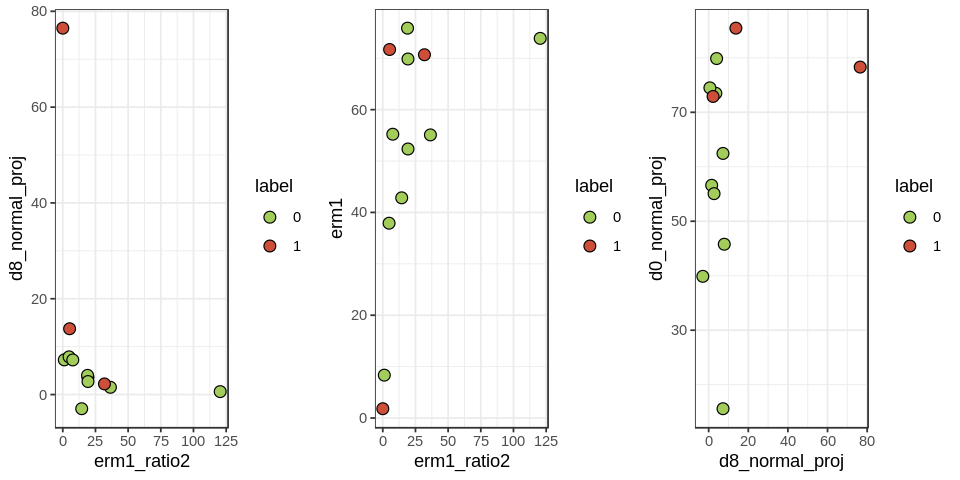

In [257]:
# TO-DO: Return D8-D33 ERM, D33-N distances, D8-N distances
# Plot pair-wise plots of the above
v_hyperdiploid <- list_results[['TEL-AML1']]
v_y <- cbind(
  v_hyperdiploid,
  yeoh_label[rownames(v_hyperdiploid), ]
)

ax1 <- ggplot(v_y, aes(erm1_ratio2, d8_normal_proj, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

ax2 <- ggplot(v_y, aes(erm1_ratio2, erm1, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

ax3 <- ggplot(v_y, aes(d8_normal_proj, d0_normal_proj, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

plot_grid(ax1, ax2, ax3, nrow = 1)
# D33-N distances correlated with CD19 expression level of D33?

In [194]:
## M1: Entire data (with Hyperdiploid, Others)
list_feat_boxplots <- lapply(list_results, function(obj) plot_boxplots(obj$X_y))
names(list_feat_boxplots) <- subtypes6

for (subtype in subtypes6) {
  wpath <- sprintf("~/Dropbox/tmp/d0_d33-%s.pdf", subtype)
  ggsave(wpath, list_feat_boxplots[[subtype]],
         width = 7, height = 2.3)
}

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

### Plot boxplots of features

In [26]:
## M1: Entire data (with Hyperdiploid, Others)
boxplots <- lapply(list_obj1, function(obj) plot_boxplots1(obj$X_y))

  label treatment_type             feature    value
1     0            BMT angle_d0d8_d0normal 19.30266
2     0             HR angle_d0d8_d0normal 14.60372
3     0            BMT angle_d0d8_d0normal 40.11626
4     1             HR angle_d0d8_d0normal 28.33446
5     1            BMT angle_d0d8_d0normal 64.26825
6     1             HR angle_d0d8_d0normal 53.41166


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             SR angle_d0d8_d0normal 42.50210
2     0             SR angle_d0d8_d0normal 28.47382
3     0             IR angle_d0d8_d0normal 33.15841
4     1             SR angle_d0d8_d0normal 77.99727
5     0             SR angle_d0d8_d0normal 32.41103
6     0             SR angle_d0d8_d0normal 29.78878
  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 41.73178
2     1             IR angle_d0d8_d0normal 50.76522
3     0             SR angle_d0d8_d0normal 46.81432
4     0             SR angle_d0d8_d0normal 52.80239
5     0             IR angle_d0d8_d0normal 32.49134
6     0             SR angle_d0d8_d0normal 31.99495


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 35.84321
2     1             HR angle_d0d8_d0normal 40.90082
3     1             HR angle_d0d8_d0normal 51.77312
4     1             HR angle_d0d8_d0normal 48.53450
5     0             HR angle_d0d8_d0normal 34.30453
6     1            BMT angle_d0d8_d0normal 37.42251


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 51.72514
2     0             IR angle_d0d8_d0normal 33.58666
3     0             IR angle_d0d8_d0normal 21.11545
4     1             SR angle_d0d8_d0normal 36.43210
5     0             HR angle_d0d8_d0normal 52.41036
6     0             SR angle_d0d8_d0normal 46.95497


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 24.74263
2     0             HR angle_d0d8_d0normal 30.05835
3     0             SR angle_d0d8_d0normal 25.96107
4     1             HR angle_d0d8_d0normal 42.59169
5     0             IR angle_d0d8_d0normal 21.92089
6     0             HR angle_d0d8_d0normal 51.81245


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             SR angle_d0d8_d0normal 32.17983
2     0             SR angle_d0d8_d0normal 39.77896
3     0             IR angle_d0d8_d0normal 45.93771
4     0             SR angle_d0d8_d0normal 49.05885
5     0             SR angle_d0d8_d0normal 33.22928
6     0             HR angle_d0d8_d0normal 65.35109


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [57]:
for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/_alltrain_wilcox-%s.pdf", subtypes7[i])
  ggsave(wpath, list_feat_boxplots[[i]],
         width = 7, height = 2.3)
}

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### M1: Train/test

In [22]:
#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
predict_pipeline_test <- function(
  sid_subtype, X_normal,
  metadata, metadata_mrd,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, X
) {  
  sid_subtype_train <- intersect(sid_subtype, sid_train)
  sid_subtype_test <- intersect(sid_subtype, sid_test)
  
  subtype_train <- X[, sid_train, drop = F]
  subtype_test <- X[, sid_test, drop = F]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(subtype_train, sid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X[selected_genes, sid_subtype, drop = F])
  normal <- t(X[selected_genes, sid_normal, drop = F])
  
  # Compute features on both train and test
  V <- compute_features(response, normal, sid_train, sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"] # append column
  
  print(sid_subtype_train)
  print(sid_subtype_test)
  if (!(is_paired(sid_subtype_train)))
    stop("sample ids are not paired")
  if (!(is_paired(sid_subtype_test)))
    stop("sample ids are not paired")
  
  pid_subtype_train <- unique(substring(sid_subtype_train, 1, 4))
  pid_subtype_test <- unique(substring(sid_subtype_test, 1, 4))
  
  V_train <- V[pid_subtype_train, , drop = F ]
  V_test <- V[pid_subtype_test, , drop = F ]
  
  obj_train <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  obj_test <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd"),
    V_test
  )
  
  list(train = obj_train, test = obj_test)
}

### M1: Test set 1 (w/o Hyp, Others)

In [23]:
list_subtypes5 <- lapply(
  subtypes5,
  function(subtype) sid_alltrain_local[
    Y[sid_alltrain_local, "subtype"] == subtype
  ]
)

list_m1_train_test <- lapply(
  list_subtypes5,
  predict_pipeline_test,
  X_normal, Y, yeoh_label,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, data
)

list_m1_train <- lapply(list_m1_train_test, function(obj) obj$train)
list_p_rem_train <- lapply(list_m1_train, function(obj) obj$p_rem)
m1_p_train <- do.call(rbind, list_p_rem_train)
                           
list_m1_test <- lapply(list_m1_train_test, function(obj) obj$test)
list_p_rem_test <- lapply(list_m1_test, function(obj) obj$p_rem)
m1_p_test <- do.call(rbind, list_p_rem_test)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0"
[1] "NO. OF SAMPLES IN CENTROID: 4"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8"
[15] "P134_D8" "P152_D8" "P170_D8" "P184_D8"
[1] "P175_D0" "P175_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P145_D0" "P161_D0"
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "P049_D0" "P050_D0" "P051_D0" "P049_D8" "P050_D8" "P051_D8"
[1] "P102_D0" "P145_D0" "P161_D0" "P102_D8" "P145_D8" "P161_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P160_D0" "P167_D0" "P211_D0"
[1] "NO. OF SAMPLES IN CENTROID: 2"
[1] "P058_D0" "P122_D0" "P160_D0" "P167_D0" "P058_D8" "P122_D8" "P160_D8"
[8] "P167_D8"
[1] "P131_D0" "P137_D0" "P211_D0" "P131_D8" "P137_D8" "P211_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P103_D0" "P116_D0" "P151_D0"
[1] "NO. OF SAMPLES IN CENTROID: 7"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
 [8] "P116_D0" "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P010_D8"
[15] "P012_D8" "P116_D8"
[1] "P103_D0" "P151_D0" "P103_D8" "P151_D8"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 888"
[1] "No. of features (p-value) = 2036"
[1] "No. of features (log2-fc) = 238"
[1] "No. of class genes = " "237"                  
[1] "No. of selected genes = " "183"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P127_D0" "P135_D0"
[29] "P136_D0" "P147_D0" "P156_D0" "P165_D0" "P166_D0" "P172_D0"
[1] "NO. OF SAMPLES IN CENTROID: 20"
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P165_D0" "P172_D0" "P013_D8" "P014_D8" "P015_D8" "P016_D8"
[29] "P017_D8" "P

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [24]:
write.table(m1_p_train, "tmp/m1-p_train.tsv", quote = F, sep = "\t")
write.table(m1_p_test, "tmp/m1-p_test.tsv", quote = F, sep = "\t")

### Plot: Jitter

### Training data (w Hyper, Others)

In [93]:
X_normal <- data[, rownames(Y)[Y$class_info == "N"]]
list_X_subtype1 <- lapply(
  subtypes,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj1 <- lapply(
  list_X_subtype1,
  predict_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of selected genes = " "80"                      
[1] "No. of final genes = " "66"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [526]:
# #' Plots boxplot of features, p_rem and global ERM
# #' Provides p-values of log(mrd), p_rem and global ERM
# plot_boxplots1 <- function(X_y) {
#   COL_LABEL <- c("darkolivegreen3", "tomato3")
#   FEAT_ORDER <- c(
#     "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
#     "log_mrd", "global_erm", "p_rem"
#   )
#   FEAT_LABS <- c(
#     "'ERM Ratio'", "'ARM Ratio'", "theta",
#     "log[10](MRD)", "'Global ERM'", "paste('P(Remission|', bold(x), ')')"
#   )
  
#   long_X_y <- melt(X_y, id = "label", variable.name = "feature")

#   # Reorder levels and label features
#   long_X_y$feature <- factor(
#     long_X_y$feature,
#     levels = FEAT_ORDER,
#     labels = FEAT_LABS
#   )
  
#   ax_jitter <- ggplot(
#     long_X_y,
#     aes(x = feature, y = value, colour = label)
#   ) +
#     geom_boxplot(alpha = 0, show.legend = F) +
#     geom_point(
#       position = position_jitterdodge(),
#       cex = 2, # pch = 21, colour = "black",
#       show.legend = F
#     ) +
#     scale_colour_manual(values = COL_LABEL) +
#     facet_wrap(
#       ~feature,
#       nrow = 1, scales = "free",
#       labeller = label_parsed
#     ) +
#     theme(
#       axis.title.x = element_blank(),
#       axis.text.x = element_blank(),
#       axis.ticks.x = element_blank(),
#       axis.title.y = element_blank(),
#       legend.position = "none"
#     )
  
#   # Jitter plot: p-value label
#   # Both group sizes must be > 1
#   if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
#     p_labs <- sapply(
#       FEAT_ORDER,
#       function(idx) {
#         list_feat <- split(X_y[, idx], X_y$label)
#         tryCatch(
#           {
#             htest <- ks.test(list_feat[[1]], list_feat[[2]])
#             sprintf("p = %.3f", htest$p.value)
#           },
#           error = function(err) {
#             print(err)
#             return(err)
#           }
#         )
#       }
#     )
    
#     ann_text <- data.frame(
#       feature = factor(
#         FEAT_ORDER,
#         levels = FEAT_ORDER,
#         labels = FEAT_LABS
#       ),
#       value = c(
#         max(X_y[FEAT_ORDER[1]]),
#         max(X_y[FEAT_ORDER[2]]),
#         min(X_y[FEAT_ORDER[3]]),        
#         min(X_y[FEAT_ORDER[4]]),
#         max(X_y[FEAT_ORDER[5]]),
#         max(X_y[FEAT_ORDER[6]])
#       ),
#       lab = p_labs
#     )
#     ann_text <- na.omit(ann_text)

#     ax_jitter <- ax_jitter +
#       geom_label(data = ann_text,
#                   aes(x = feature, y = value, label = lab),
#                   size = 3, colour = "black",
#                   alpha = 0.5, hjust = 0)
#   }
  
#   ax_jitter
# }

### Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


#### Plot x v.s. TPR

In [ ]:
plot_tpr1 <- function(x, name, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  plot(TPR, sort_x, ylab = name, col = col, type = "l")
}


plot_tpr2 <- function(x, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  lines(TPR, sort_x, col = col, type = "l")
}

cols <- ggplot_palette(4)
features <- c("ERM", "p", "p (w/o MRD)", "-log10(MRD)")

pdf("~/Dropbox/temp/tpr_x.pdf", 6, 6)
plot_tpr1(normaliseMinmax(p_y_sub$erm1), "x", cols[1])
plot_tpr2(p_y_sub$p, cols[2])
plot_tpr2(p_y_sub$p_wo, cols[3])
plot_tpr2(normaliseMinmax(-log10(p_y_sub$d33_mrd)), cols[4])
legend("topleft", legend = features, col = cols, lwd=2)
dev.off()

### Plot odds ratio

In [12]:
plot_odds_ratio <- function(P) {
  COL_LABEL <- c("darkolivegreen3", "tomato3")
  
  odds_prior <- table(P$label)[2] / table(P$label)[1] # rel/rem
  FEATURES <- c("erm1_ratio2", "l2norm_ratio2",
                "mrd", "angle_d0d8_d0normal")
  P_REM <- P[, FEATURES]
  
  compute_odds_ratio <- function(X, odds_prior) {
    (1-X) / (X * odds_prior)
  }

  odds_ratio <- data.matrix(compute_odds_ratio(P_REM, odds_prior))
  odds_ratio[is.infinite(odds_ratio)] <-
    max(odds_ratio[!is.infinite(odds_ratio)]) * 2 # replace with max * 2
  data <- cbind(
    P[, c("pid", "label")],
    odds_ratio
  )

  long_data <- melt(data, id.vars = c("pid", "label"))
  
  ggplot(long_data, aes(x = label, y = value, colour = label)) +
    geom_point(position = position_jitter(height = 0), cex = 3) +
    facet_wrap(~variable, nrow = 1, scales = "free_x") +
    scale_color_manual(values = COL_LABEL)
}

In [520]:
list_odds_ratio <- lapply(list_obj1, function(obj) plot_odds_ratio(obj$P))
for (i in seq_along(list_odds_ratio)) {
  wpath <- sprintf("~/Dropbox/temp/OR-%s.pdf", subtypes[i])
  ggsave(wpath, list_odds_ratio[[i]], width = 8, height = 3)
}

## Subnetworks

In [8]:
# 1. Removes affymetrix ambiguous and control probesets
# 2. Map probesets to IDs
# Removes one-to-many probesets and probesets with no ID
# Selects maximum if two probesets match to same gene
# CHECK: What microarray platform is the data from?
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_data <- affy2id(data, ENTREZ_GPL570)

## SYMBOL_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
## symbol_yeoh <- affy2id(data_yeoh, SYMBOL_GPL570)

No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [572]:
# Calculate individual D0-N magnitude (normal centroid)
normal <- entrez_data[, startsWith(colnames(entrez_data), "N")]
D0 <- entrez_data[, endsWith(colnames(entrez_data), "D0")]
D8 <- entrez_data[, endsWith(colnames(entrez_data), "D8")]

#### Unfiltered data

In [573]:
raw_data <- log2_transform(selected_yeoh)
araw <- affy2id(raw_data, ENTREZ_GPL570)
lidx1 <- sapply(subnetwork_nea,
                function(ids) all(ids %in% rownames(araw)))
subnetwork2 <- subnetwork_nea[lidx1]
print(length(subnetwork2))
                
# Calculate individual D0-N magnitude (normal centroid)
normal_raw <- araw[, startsWith(colnames(araw), "N")]
D0_raw <- araw[, endsWith(colnames(araw), "D0")]
D8_raw <- araw[, endsWith(colnames(araw), "D8")]

No. of probesets mapping to multiple IDs removed: 412
No. of probesets with no ID removed: 1010
Total no. of probesets removed (incl. probesets mapping to same gene): 4185
[1] 4715


#### Import subnetworks

In [ ]:
## Import NEA subnetworks
NEA_RPATH <- paste0("../diff_expr/data/subnetwork/nea-hsa/",
                    "ovarian_cancer/geneset-nea_kegg_ovarian.tsv")
nea_df <- read.table(NEA_RPATH, sep = "\t", header = T, stringsAsFactors = F)
subnetwork_nea <- split(as.character(nea_df$gene_id), nea_df$subnetwork_id)

In [570]:
# Filter out subnetworks with genes that are missing in the data
lidx <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(entrez_data)))
nea_fltr <- subnetwork_nea[lidx]
               
lidx1 <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(araw)))
nea_unfltr <- subnetwork_nea[lidx1]

In [728]:
print(length(subnetwork_nea))
print(length(nea_unfltr))

[1] 4715
[1] 4715


#### Only half of the KEGG ids are represented in the data

In [539]:
## Import KEGG pathways
KEGG_RPATH <- "../info/KEGG/kegg-human_allpathway_genes.tsv"
kegg_df <- read.table(KEGG_RPATH, sep = "\t", header = T, stringsAsFactors = F)
kegg_df$Pathway <- substring(kegg_df$Pathway, 6)
list_kegg <- split(kegg_df$Entrez.Gene.ID, kegg_df$Pathway)

In [549]:
sum(unique(unlist(list_kegg)) %in% rownames(araw))

[1] 3839

In [551]:
# kegg_size <- sapply(subnetwork_pwapi, length)
# kegg_hit <- sapply(subnetwork_pwapi,
#                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data
incomplete_kegg <- lapply(list_kegg,
                          function(ids) ids[ids %in% rownames(araw)])
kegg_size <- sapply(incomplete_kegg, length)
SIZE <- 5
incomplete_kegg_sub <- incomplete_kegg[kegg_size > SIZE]
kegg_size1 <- sapply(incomplete_kegg_sub, length)

In [417]:
## Import pathwayAPI
PWAPI_RPATH <- "../info/pathwayAPI/pwapi_id_human-filtered_entrez.tsv"
pwapi_df <- read.table(PWAPI_RPATH, sep = "\t", header = T, stringsAsFactors = F)
list_pwapi <- split(pwapi_df[,2:3], pwapi_df$pathway_id)
subnetwork_pwapi <- lapply(list_pwapi,
                           function(X) unique(as.numeric(data.matrix(X))))

In [466]:
pwapi_size <- sapply(subnetwork_pwapi, length)
pwapi_hit <- sapply(subnetwork_pwapi,
                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data in pathwayAPI
subnetwork_pwapi_sub <- lapply(subnetwork_pwapi,
                                function(ids) ids[ids %in% rownames(araw)])
pwapi_size1 <- sapply(subnetwork_pwapi_sub, length)
SIZE <- 5
subnetwork_pwapi_sub1 <- subnetwork_pwapi_sub[pwapi_size1 > SIZE]
pwapi_size2 <- sapply(subnetwork_pwapi_sub1, length)
print(cbind(pwapi_hit[pwapi_size1 > SIZE], pwapi_size2))

             pwapi_size2
pwapi002  10          10
pwapi003 144         144
pwapi004  36          36
pwapi005  67          67
pwapi006  39          39
pwapi007  43          43
pwapi008  14          14
pwapi012   6           6
pwapi016  11          11
pwapi017  28          28
pwapi018  24          24
pwapi019  23          23
pwapi020  29          29
pwapi021  44          44
pwapi022  55          55
pwapi023   8           8
pwapi024 116         116
pwapi025  30          30
pwapi026  17          17
pwapi029  75          75
pwapi030 139         139
pwapi031  27          27
pwapi032  27          27
pwapi033  27          27
pwapi034  28          28
pwapi036  13          13
pwapi037  22          22
pwapi038  12          12
pwapi040  16          16
pwapi041  18          18
pwapi042  10          10
pwapi044  32          32
pwapi045 108         108
pwapi046  54          54
pwapi048  68          68
pwapi049  32          32
pwapi050  11          11
pwapi051  23          23
pwapi052  28          28


#### Subnetwork deltas (D0-N)
- Comparing variance of subnetwork deltas was not conclusive
- Means of the random sample seem to have a larger proportion of higher mean subnetworks

- Sum of deltas (D0-D8) is not a good feature
- Percentage of sum of deltas is not a good feature
    - Does not take into account the sign of the logfc
    - Does not consider individual subnetwork
- Percentage of each subnetwork
    - Filter out subnetwork that has delta_D0N of less than threshold?

In [571]:
#' @param ids vector of gene IDs belonging to a subnetwork
#' @param X dataframe of expr values at D0
#' @param Y vector or dataframe of expr values at specific timepoint
#' @return vector of deltas of patients of a particular subnetwork
calc_subnetwork_delta <- function(ids, X, Y) {
  if(is.numeric(ids)) # how to handle factor?
    ids <- as.character(ids)
  
  if (is.vector(Y)) {
    logfc <- Y[ids] - X[ids,]
  } else {
    stopifnot(substring(colnames(X),1,4) ==
              substring(colnames(Y),1,4))
    logfc <- Y[ids,] - X[ids,]
  }
  return(colMeans(abs(logfc)))
}

#### Filtered data - NEA

In [574]:
norm_centroid <- rowMeans(normal)

delta_D0N <- data.frame(t(sapply(nea_fltr,
                                 calc_subnetwork_delta,
                                 D0, norm_centroid)))
delta_D0D8 <- data.frame(t(sapply(nea_fltr,
                                  calc_subnetwork_delta,
                                  D0, D8)))

In [658]:
print(length(nea_unfltr))

[1] 4715


[1] "BCR-ABL"
[1] 9


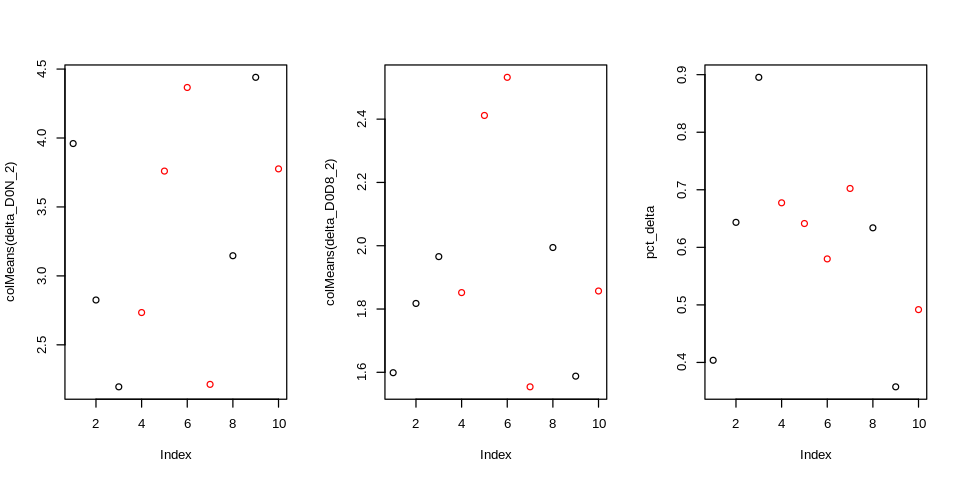

In [669]:
subtype <- subtypes[[1]]
print(subtype)
delta_D0N_1 <- delta_D0N[
  , Y[colnames(delta_D0N), "subtype"] == subtype
]
delta_D0D8_1 <- delta_D0D8[
  , Y[colnames(delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

mu_delta <- apply(delta_D0N_1, 1, mean)
var_delta <- apply(delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)

THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))
delta_D0D8_2 <- delta_D0D8_1[idx_subnetwork, ]
delta_D0N_2 <- delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- colMeans(delta_D0D8_2) / colMeans(delta_D0N_2)

par(mfrow=c(1,3))
plot(colMeans(delta_D0N_2), col = Y[names(pct_delta), "label"] + 1)
plot(colMeans(delta_D0D8_2), col = Y[names(pct_delta), "label"] + 1)
plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

In [662]:
print(colnames(delta_D0D8_1)[Y[colnames(delta_D0D8_1), "label"] == 1])

[1] "P056_D8" "P057_D8" "P134_D8" "P152_D8" "P184_D8"


[1] 0 0 0 0 0 0
Levels: 0 1
[1] TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1
9 Levels: BCR-ABL E2A-PBX1 Hyperdiploid Hypodiploid MLL Normal ... TEL-AML1


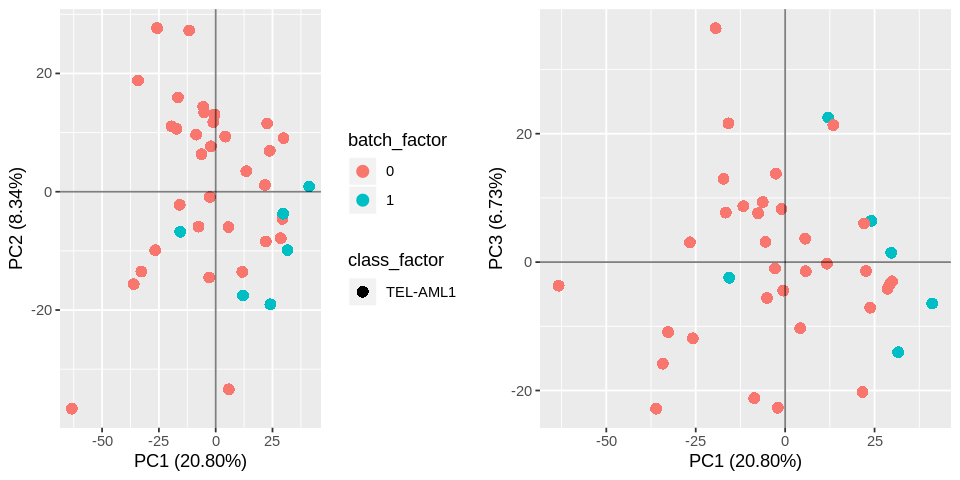

In [653]:
plotPCA2D(raw_delta_D0D8_1, Y)

#### Unfiltered data - NEA

In [641]:
norm_centroid1 <- rowMeans(normal_raw)

raw_delta_D0N <- data.frame(t(sapply(nea_unfltr,
                                 calc_subnetwork_delta,
                                 D0_raw, norm_centroid1)))
raw_delta_D0D8 <- data.frame(t(sapply(nea_unfltr,
                                  calc_subnetwork_delta,
                                  D0_raw, D8_raw)))

In [734]:
for (subtype in subtypes) {
  print(subtype)
  raw_delta_D0N_1 <- raw_delta_D0N[
    , Y[colnames(raw_delta_D0N), "subtype"] == subtype
  ]
  raw_delta_D0D8_1 <- raw_delta_D0D8[
    , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
  ]

  stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
            substring(colnames(raw_delta_D0D8_1),1,4))

  mu_delta <- apply(raw_delta_D0N_1, 1, mean)
  var_delta <- apply(raw_delta_D0N_1, 1, var)
  # plot(mu_delta, var_delta)
  THRESHOLD <- 3
  idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]

  ## Selecting subnetworks with significant dysregulation
  raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
  raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

  # print(colnames(delta_D0D8_1)[
  #   Y[colnames(delta_D0D8_1), "label"] == 1
  # ])

  pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
  
  #   pct_delta_rem <- pct_delta[, Y[colnames(pct_delta), "label"] == 0]
#   mean_pct <- rowMeans(pct_delta_rem)
#   PCT <- 0.7
#   nea_responsive <- names(mean_pct)[mean_pct > PCT]
#   print(length(nea_responsive))
#   pct_delta_responsive <- colMeans(pct_delta[nea_responsive, ])

  fpath <- sprintf("~/Dropbox/temp/delta-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(raw_delta_D0N_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0N)",
       pch = 16, cex = 1.5)
  plot(colMeans(raw_delta_D0D8_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0D8)",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(pct_delta)",
       pch = 16, cex = 1.5)
#   plot(pct_delta_responsive,
#        col = Y[names(pct_delta), "label"] + 1,
#        ylab = "mean_responsive(pct_delta)")
  dev.off()
  
  ## Relapse prediction
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  feat <- predict_relapse(pid_subtype, data, pid_remission, Y,
                          batch_genes = batch_genes)  
  
  fpath <- sprintf("~/Dropbox/temp/delta_corr-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(pct_delta), feat[, "erm1_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "erm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "l2norm_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "l2norm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "angle_d0d8_normal"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "angle_d0d8_normal",
       pch = 16, cex = 1.5)
  dev.off()
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1

In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


#### Unfiltered data - PathwayAPI

In [484]:
norm_centroid1 <- rowMeans(normal_raw)

pwapi_delta_D0N <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
pwapi_delta_D0D8 <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [535]:
subtype <- subtypes[[4]]
print(subtype)
pwapi_delta_D0N_1 <- pwapi_delta_D0N[
  , Y[colnames(pwapi_delta_D0N), "subtype"] == subtype
]
pwapi_delta_D0D8_1 <- pwapi_delta_D0D8[
  , Y[colnames(pwapi_delta_D0D8), "subtype"] == subtype
]

[1] "MLL"


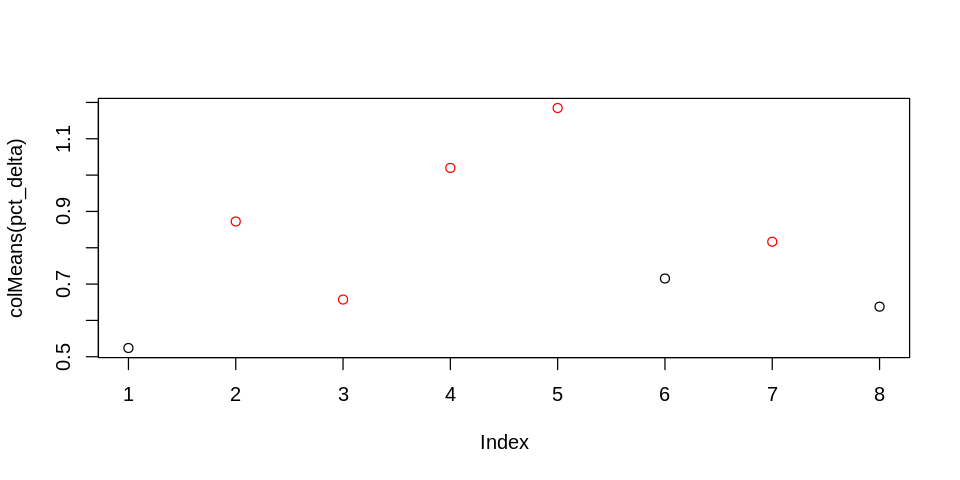

In [536]:
stopifnot(substring(colnames(pwapi_delta_D0N_1),1,4) ==
          substring(colnames(pwapi_delta_D0D8_1),1,4))

pwapi_mu_delta <- apply(pwapi_delta_D0N_1, 1, mean)
pwapi_var_delta <- apply(pwapi_delta_D0N_1, 1, var)
# plot(pwapi_mu_delta, pwapi_var_delta)

THRESHOLD <- 2.5
idx_subnetwork3 <- names(pwapi_mu_delta)[pwapi_mu_delta > THRESHOLD]
pwapi_delta_D0D8_2 <- pwapi_delta_D0D8_1[idx_subnetwork3, ]
pwapi_delta_D0N_2 <- pwapi_delta_D0N_1[idx_subnetwork3, ]

# print(colnames(pwapi_delta_D0D8_1)[
#   Y[colnames(pwapi_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- pwapi_delta_D0D8_2 / pwapi_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Unfiltered data - KEGG

In [552]:
norm_centroid1 <- rowMeans(normal_raw)

kegg_delta_D0N <- data.frame(t(sapply(incomplete_kegg_sub,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
kegg_delta_D0D8 <- data.frame(t(sapply(incomplete_kegg_sub,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [566]:
subtype <- subtypes[[7]]
print(subtype)
kegg_delta_D0N_1 <- kegg_delta_D0N[
  , Y[colnames(kegg_delta_D0N), "subtype"] == subtype
]
kegg_delta_D0D8_1 <- kegg_delta_D0D8[
  , Y[colnames(kegg_delta_D0D8), "subtype"] == subtype
]

[1] "TEL-AML1"


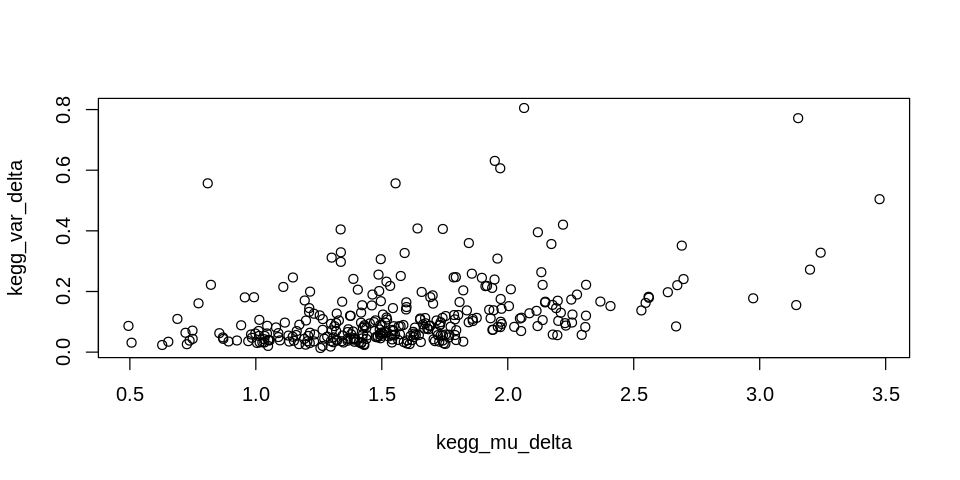

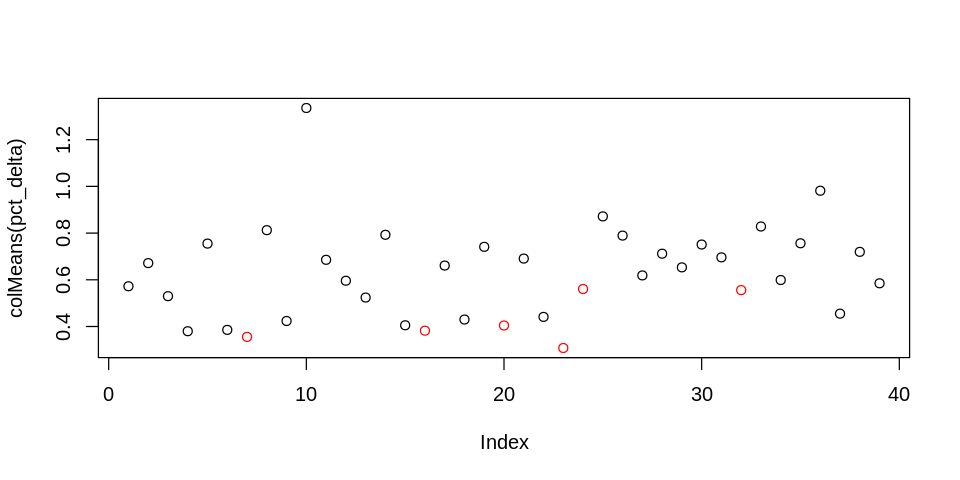

In [567]:
stopifnot(substring(colnames(kegg_delta_D0N_1),1,4) ==
          substring(colnames(kegg_delta_D0D8_1),1,4))

kegg_mu_delta <- apply(kegg_delta_D0N_1, 1, mean)
kegg_var_delta <- apply(kegg_delta_D0N_1, 1, var)
plot(kegg_mu_delta, kegg_var_delta)

THRESHOLD <- 2
idx_subnetwork4 <- names(kegg_mu_delta)[kegg_mu_delta > THRESHOLD]
kegg_delta_D0D8_2 <- kegg_delta_D0D8_1[idx_subnetwork4, ]
kegg_delta_D0N_2 <- kegg_delta_D0N_1[idx_subnetwork4, ]

# print(colnames(kegg_delta_D0D8_1)[
#   Y[colnames(kegg_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- kegg_delta_D0D8_2 / kegg_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Misc

In [49]:
## Distribution of subnetwork sizes
subnetwork_sizes <- sapply(subnetwork_nea, length)
print(table(subnetwork_sizes))

## Representation of gene IDs in data
all_ids <- unlist(subnetwork_nea)
print(head(sort(names(table(all_ids)))))
print(head(sort(rownames(entrez_data))))

[1] "10"        "100"       "10000"     "10010"     "100131827" "10014"    
[1] "100"       "10000"     "10001"     "10005"     "10010"     "100127972"


#### Data
- 405 samples (201 D0, 201 D8,3 N)
- Originally 210 patients
- Removed 2 outliers, 7 different batches

In [ ]:
LABEL_RPATH <- "data/GSE67684/processed/metadata/pid-metadata_v5.tsv"